## Difference of basin boundary for Stommel and non-Stommel

Import packages:

In [4]:
import numpy as np
from numpy.polynomial import Polynomial as pol
from matplotlib import pyplot as plt
import matplotlib as mpl

Import own modules:

In [5]:
import import_ipynb
from SETUP import f, J, IinTprep, IinT, TSslow, findT

In [6]:
plt.rcParams['figure.constrained_layout.use'] = False
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Arial'], 'size':20, 'weight':'normal'})

In [7]:
def get_eqlst(eqlst_pre):
    '''Helper function to select true equilibria from list of candidates'''
    eqlst = []
    for i in range(len(eqlst_pre)):
        Tval = eqlst_pre[i][0]
        flag = False
        j = 0
        while j in range(len(eqlst)) and flag == False:
            if abs(Tval-eqlst[j][0]) < 0.1:
                flag = True
                j += 1
            else:
                j += 1

        if flag == False:
            eqlst.append(eqlst_pre[i])
            
    return eqlst

0.19152723143243466
0.0 [(1.7286880361313495, 1.1843257435116965, 2.1872806708346686, 1.89), (2.4124740170650085, 2.5107598231331263, 2.3206227122474536, 1.8)]

-0.15847276856756531
0.23703596748230304 [(1.704487766017008, 1.0692722428866377, 1.4092393776370418, 1.8), (2.550783619014345, 2.630883996436685, 1.621838744237662, 2.06)]

-0.30847276856756534
1.7370359674823033 [(2.627499489341171, 2.698126969547451, 1.2379261091615377, 2.06)]



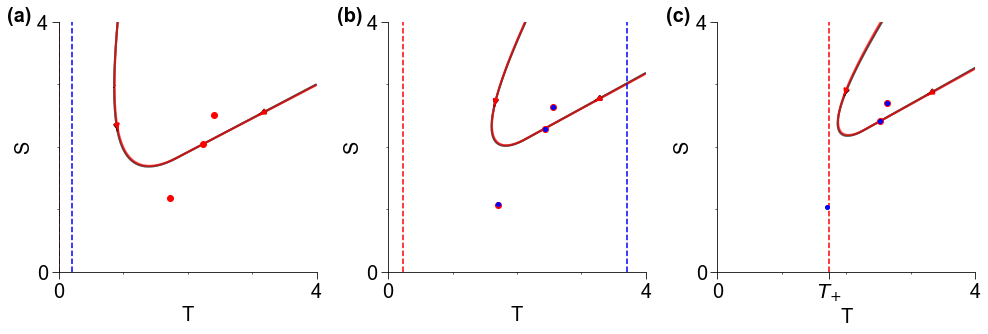

In [11]:
e1 = 3
e2 = 1
e3 = 0.3
D = 0.86
B = 0.45
R0 = -0.1
k = 0.151
dx = 0.01
t = 100
dt = 0.01

c = 0.1
i1 = np.arccosh(np.sqrt(D/(B-R0)))
i2 = -np.arccosh(np.sqrt(D/B))
lpl = D*np.tanh(i1) + (R0-B)*i1
lmin = D*np.tanh(i2) - B*i2

R_crit5 = -(c*max(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1) # = R_ion^off

T_sn = 1.8968299744885446
e1_sn = 2.549292519519159
I_sn = (e1-e1_sn)/k
R_sn = -(D*np.tanh(I_sn) + (R0-B)*I_sn)
R_crit3 = R_sn - c*T_sn

plt.figure(figsize=(14,5))
ngrid = 200
lw = 3
plt_ind = 1

T_max = 4
T_min = 0
S_max = 4
S_min = 0
ngrid = 200
T = np.linspace(T_min, T_max, ngrid)
S = np.linspace(S_min, S_max, ngrid)
lw = 2
density = 200

dT = np.zeros((ngrid, ngrid))
dS = np.zeros((ngrid, ngrid)) 


for R in [R_crit5+0.6, R_crit5+0.25, R_crit5+0.1]:
    print(R)
    dTm = np.zeros((ngrid, ngrid))
    dSm = np.zeros((ngrid, ngrid))
    dTm2 = np.zeros((ngrid, ngrid))
    dSm2 = np.zeros((ngrid, ngrid))
    dTm3 = np.zeros((ngrid, ngrid))
    dSm3 = np.zeros((ngrid, ngrid))
    dTp = np.zeros((ngrid, ngrid))
    dSp = np.zeros((ngrid, ngrid))
    
    plt.subplot(1,3,plt_ind)
    
    
    T_u, T_l, I_u, I_l = IinTprep(R, dx, c, Tmax=20, Imin=-20, Imax=20)
    T_l[-1] = -1/c*(lmin+R)
    ice = [T_u, T_l, I_u, I_l]
 
    e1new = e1-k*IinT(findT(R,c,k), 1, R, dx, c, T_u, T_l, I_u, I_l)

    spt = f(e1new, e2, e3)[0]
    plt.plot(spt[1], spt[0], 'ro')
    
    
    ## Set up Stommel vector field
    for i in range(ngrid):
        for j in range(ngrid):
            dT[j][i] = e1new - T[i]*(1+np.abs(T[i]-S[j]))
            dS[j][i] = e2 - S[j]*(e3+np.abs(T[i]-S[j]))

    ## Set up vector field on M_0^+
    for i in range(1+int(T_u[0]*ngrid/T_max), ngrid):
        for j in range(ngrid):
            I_term = 1
            I_term = IinT(T[i], I_term, R, dx, c, T_u, T_l, I_u, I_l)
            dTp[j][i] = e1 - k*np.heaviside(I_term, 0)*I_term - T[i]*(1+abs(T[i]-S[j]))
            dSp[j][i] = e2 - S[j]*(e3+abs(T[i]-S[j]))
    
        ## Some particular streamlines on M_0^+
    start_points_p = [(1.8, 2), (2.06, 2.21), (2.32, 2.43), (2.48, 2.57), (2.59, 2.67), (2.6, 2.65), (max(f(e1-k*i1, e2, e3))[1], max(f(e1-k*i1, e2, e3))[0]),
                 (1.89, 1.54), (1.75, 1.25), (1.72, 1.15), (1.70, 1.07), (min(f(e1-k*i1, e2, e3))[1], min(f(e1-k*i1, e2, e3))[0])] # 1st line is off, 2nd is on


    ## Stable fixed points on M_0^+
    eqlst_pre = []
    for start_pt in start_points_p:
        T0 = start_pt[0]
        S0 = start_pt[1]

        if T_u[0]-0.0001 <= T0 <= T_u[-1]:
            time2, I2, T2, S2 = TSslow(t, dt, T0, S0, e1, e2, e3, k, c, R, dx, ice, I_branch=1)

            # we are looking for stable fixed points on M_0^+, so we must check whether
            # the system has tipped to an ice-free state; in that case, the
            # equilibrium is not appended to the candidate list.
            if I2[-1] > 0:
                eqlst_pre.append((T2[-1], S2[-1], I2[-1], T0))
    
    eqlst = sorted(get_eqlst(eqlst_pre))
    print(T_u[0], eqlst)

    for pt in eqlst:
        if pt[0] > T_u[0]-0.001:
                plt.plot(pt[0], pt[1], 'ro')
                
    for pt in f(e1new, e2, e3):
        if pt[1] < T_l[-1]+0.001:
                plt.plot(pt[1], pt[0], 'bo', markersize=4)

    
    
    basin_bdry_points = [(spt[1], spt[0]), (spt[1]-0.0009, spt[0]-0.0007)] 
    plt.streamplot(T, S, dT, dS, start_points = basin_bdry_points, color='black', density=100, linewidth=lw, integration_direction='backward')
    plt.streamplot(T, S, dTp, dSp, start_points = basin_bdry_points, color='red', density=100, linewidth=lw, integration_direction='backward')
    
    
    
    ## Temperature threshold
    ax=plt.gca()

    plt.vlines(x = T_u[0], ymin = 0, ymax = 4, colors = 'red', ls='--')
    plt.vlines(x = T_l[-1], ymin = 0, ymax = 4, colors = 'blue', ls='--')

    ## Plotting ticks
    xticks = [0,4]
    xticklabels = [0,4]
    yticks = [0,4]
    yticklabels = [0,4]

    if len(T_u) != 0 and 0.5 < T_u[0] < 3.5:
        xticks = np.append(xticks, T_u[0])
        xticklabels = np.append(xticklabels, '$T_{\!+}$')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)


    ## Plotting labels etc.
    plt.xlabel('T')
    plt.ylabel('S')
    plt.xlim(0,4)
    plt.ylim(0,4)
    
    dic = {1: '(a)', 2: '(b)', 3: '(c)', 4: '(d)', 5: '(e)', 6: '(f)', 7: '(g)', 8: '(h)', 9: '(i)'}
    plt.text(-0.8, 4, dic[plt_ind], weight='bold')
    
    plt_ind += 1
    print('')
    
plt.tight_layout(pad=1)
plt.show()